# Setup

In [1]:
DATA_VERSION = "2025-07-07"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

# RUN_HYPEROPTIMIZATION = True
# HYPERPARAMETERS = None

RUN_HYPEROPTIMIZATION = False
# HYPERPARAMETERS = {
#     "classifier": {
#         "type": "MLP",
#         "activation": "relu",
#         "alpha": 7.347549520407708e-05,
#         "batch_size": 144,
#         "layer_1": 240,
#         "layer_2": 48,
#         "layer_3": 208,
#         "learning_rate_init": 0.00013505066692205835,
#         "n_layers": 1,
#         "solver": "adam",
#     },
#     "pca_n_components": 360,
# }
HYPERPARAMETERS = {
    "classifier": {
        "type": "SVC",
        "C": 1.0,
        "class_weight": None,
        "gamma": "scale",
        "kernel": {"type": "rbf"},
    },
    "pca_n_components": 100,
}

assert RUN_HYPEROPTIMIZATION ^ bool(HYPERPARAMETERS)

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
from hyperopt import pyll

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_type_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("run_hyperoptimization", RUN_HYPEROPTIMIZATION)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = blushing-quail-761


''

# Input data preparation

## Get all dataframes

In [5]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-07.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-07-07.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-07-07.parquet already exists locally.


In [6]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,1CAJoURQMxKeqCdQ4vhCQx,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfhw8g5R8AutE4QTgn,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,1CAJoURQMxKeqCdQ564eYH,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfjrEEFeu6PDxuCd16,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfmiLy7uCJJK4xiJ4o,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,1CAJoURQbi5gxw7WpL8ns1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wfoMZEhmu1hg9dvJGj,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54060,1CQq2bBy7wV78EmA9xHazV,vsnqprpg,2025-07-04,2025-09-30,Änderung des Einführungsgesetzes zum Bundesges...,,https://www.gl.ch/public/upload/assets/61332/A...,https://www.demokratis.ch/vernehmlassung/vsnqprpg,[],[],...,Regierungsrat des Kantons Glarus,gl,1CQs68DcZyXvLYab74xtmH,openparldata,openparldata,NaN,Adressatenliste für die Vernehmlassung zur Änd...,2025/5186/56137/1CQs68DcKaQHHLjJoxiQEC.pdf,application/pdf,fb5ab47a90def22d7de4c4d02c327fec05e4e260
54061,1CQq2cR8RAR9368nVbjUV1,5dhsw32n,2025-07-04,2025-10-31,Teilrevision des Gesetzes über die Gewässer (G...,Der Regierungsrat ha

In [7]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_uuid,stored_file_hash,,,,,,,
1CAJoURQMxKeqCdQ4jLniS,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
1CAJoURQMxKeqCdQ4vhCQx,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
1CAJoURQMxKeqCdQ564eYH,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
1CAJoURQbi5gxw7Wp5N5rT,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
1CAJoURQbi5gxw7WpL8ns1,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
1CQq2bBy7wV78EmA9xHazV,fb5ab47a90def22d7de4c4d02c327fec05e4e260,False,1,0.0,0.0,0.0,0.0,1.414113
1CQq2cR8RAR9368nVbjUV1,c00322983e98a8d9b21fd77c73561c0a603abf01,True,1,1.0,1.0,0.0,0.0,1.414422
1CQq2cR8RAR9368nVgTnQ1,8bc1411784fcd8bae054adae10151b748b50de81,False,25,0.0,0.0,6.0,5.0,0.707098


In [8]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_uuid,
1CAJoURQMxKeqCdQ4jLniS,"[0.01030252780765295, -0.014312159270048141, -..."
1CAJoURQMxKeqCdQ4vhCQx,"[0.011395552195608616, 0.0014780974015593529, ..."
1CAJoURQMxKeqCdQ564eYH,"[-0.005767590366303921, 0.002646328415721655, ..."
1CAJoURQbi5gxw7Wp5N5rT,"[0.019797369837760925, -0.00907826703041792, -..."
1CAJoURQbi5gxw7WpL8ns1,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
1CQq2bBy7wV78EmA9xHazV,"[0.02759377844631672, 0.016357988119125366, -0..."
1CQq2cR8RAR9368nVbjUV1,"[0.011649553664028645, 0.0022296165116131306, ..."
1CQq2cR8RAR9368nVgTnQ1,"[0.023022599518299103, -0.015509047545492649, ..."


In [9]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [10]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1271 documents (5.3%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 3363 rows (14.9%) were lost due to missing features. Remaining rows: 19166. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    44    17    21     6     0    41     3    59    58    18    24     5     1   297.0
ai  

In [11]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    345
vs     12
bl      9
Name: count, dtype: int64


## Split

In [12]:
df_input_train, (df_input_test_1, df_input_test_2) = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=(TEST_SIZE, TEST_SIZE),
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.27% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.14% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.14% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.19% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

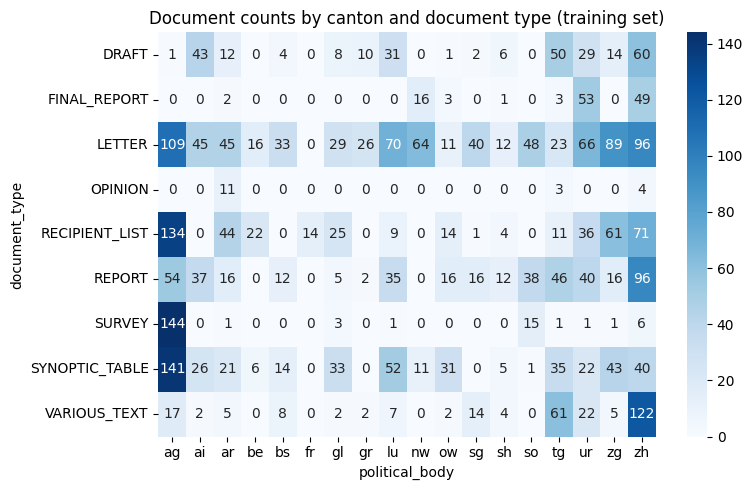

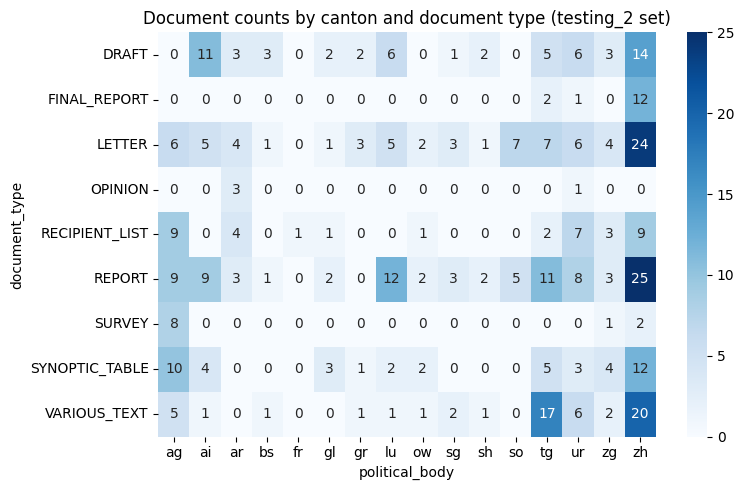

In [13]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [14]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    12359
manual     1879
rule       1173
Name: count, dtype: int64

document_type
LETTER            3304
DRAFT             3122
REPORT            2558
RECIPIENT_LIST    2188
FINAL_REPORT      1850
OPINION            907
VARIOUS_TEXT       680
SYNOPTIC_TABLE     604
SURVEY             198
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [15]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    403
fedlex      0
rule        0
Name: count, dtype: int64

document_type
REPORT            95
LETTER            79
DRAFT             58
VARIOUS_TEXT      58
SYNOPTIC_TABLE    46
RECIPIENT_LIST    37
FINAL_REPORT      15
SURVEY            11
OPINION            4
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [16]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

403

# Data exploration

## Data representation

In [17]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2851
                            LETTER            2482
                            REPORT            2117
                            RECIPIENT_LIST    1742
                            FINAL_REPORT      1723
                            OPINION            889
                            VARIOUS_TEXT       407
                            SYNOPTIC_TABLE     123
                            SURVEY              25
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
rule                        LETTER             456
                            RECIPIENT_LIST     273
                            SYNOPTIC_TABLE     266
                            SURVEY             122
                            FINAL_REPORT        56
                            DECISION   

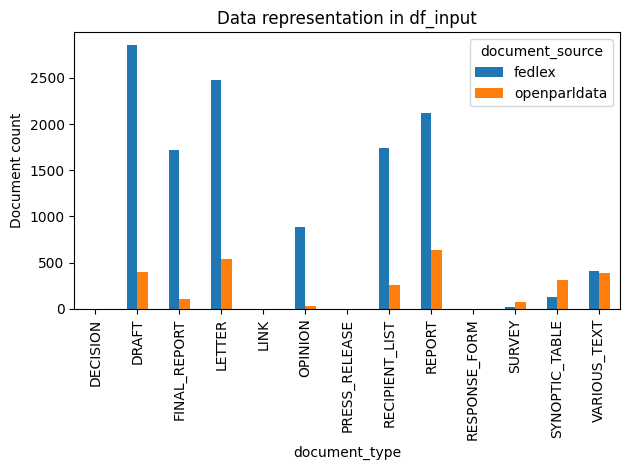

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2851,396
FINAL_REPORT,1723,111
LETTER,2482,535
LINK,0,0
OPINION,889,27
PRESS_RELEASE,0,0
RECIPIENT_LIST,1742,254
REPORT,2117,641


In [18]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [19]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001052,0.000000
FINAL_REPORT,0.002902,0.036036
LETTER,0.985093,0.996262
OPINION,0.750281,0.666667
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013226,0.051482
SURVEY,0.000000,0.040541
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014742,0.012821


### Keyword-like features

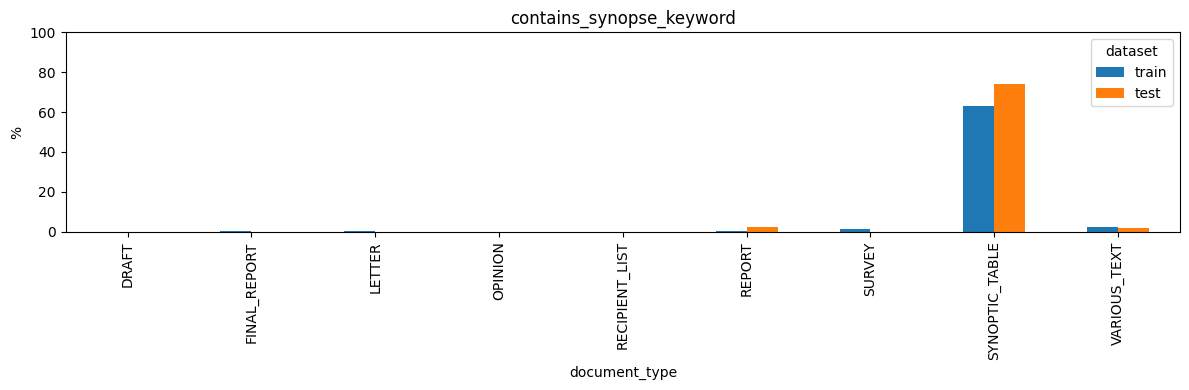

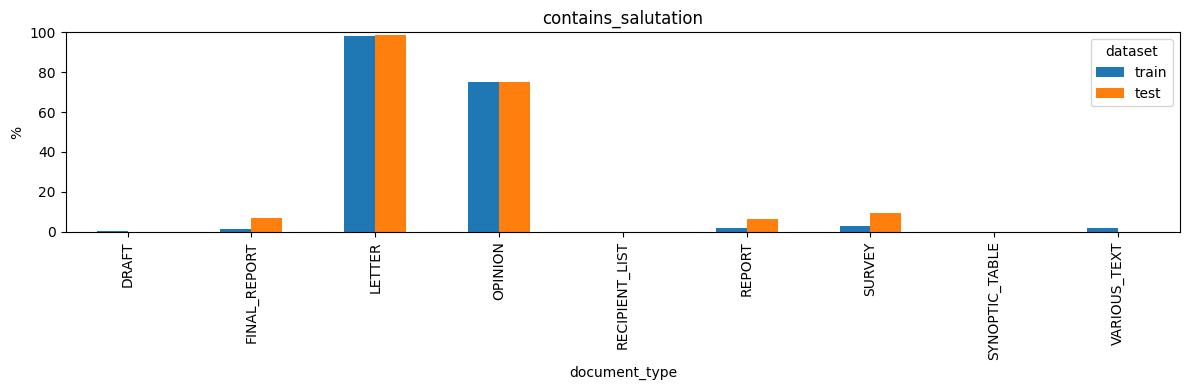

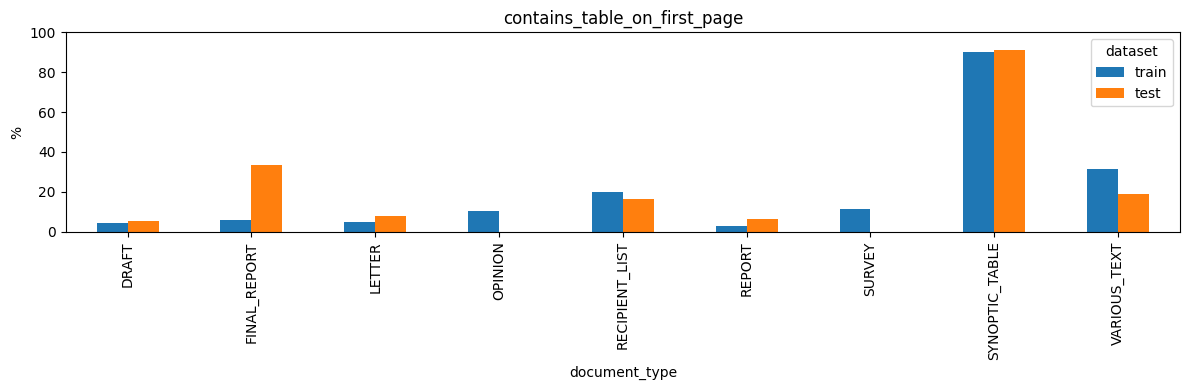

In [20]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [21]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

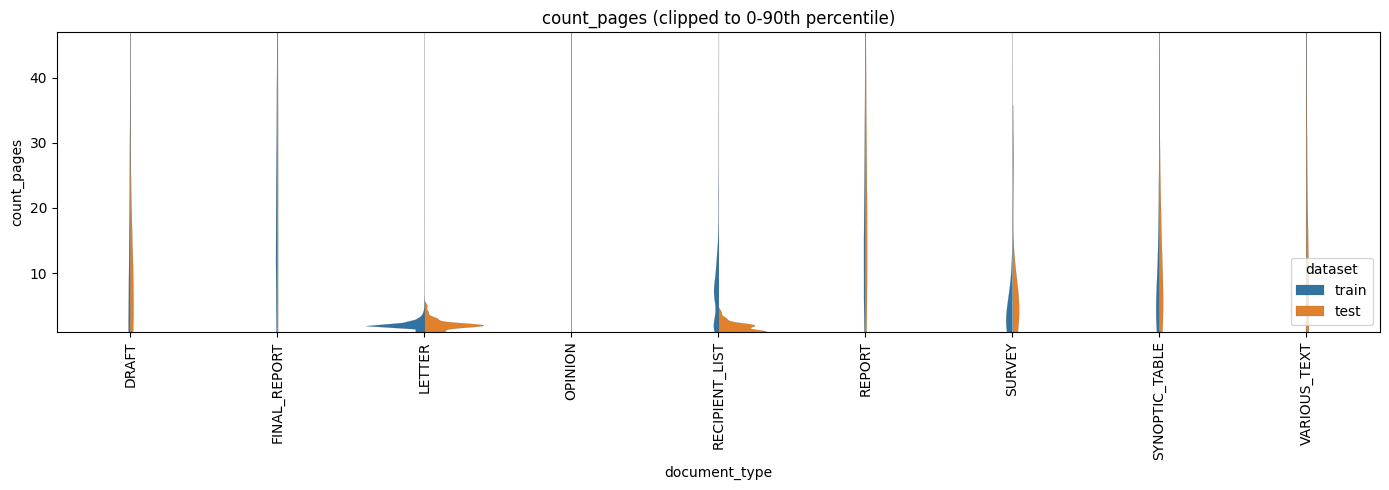

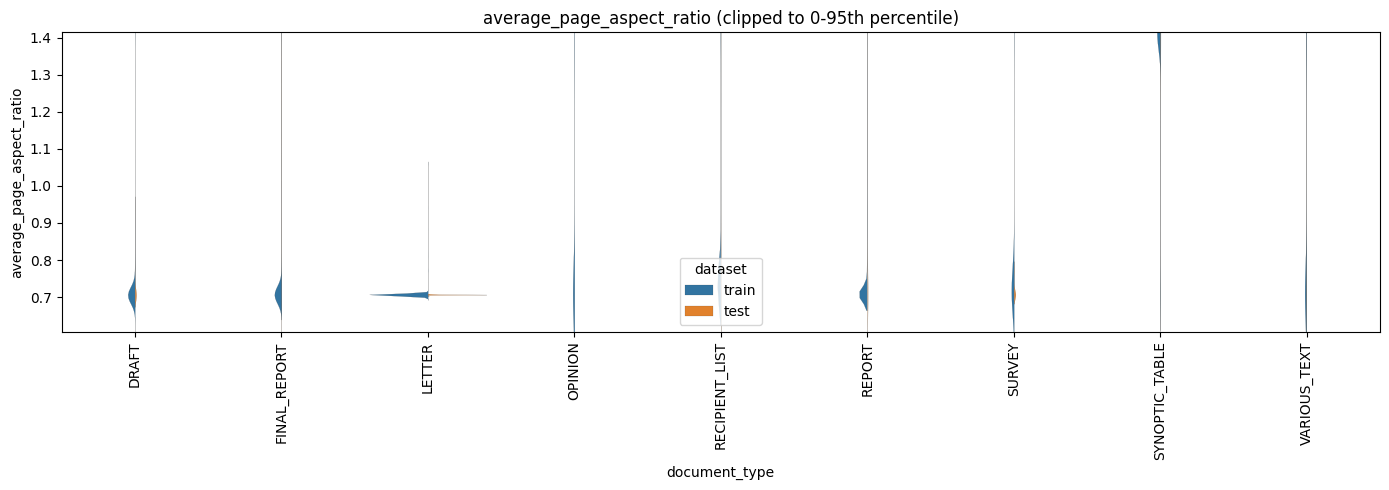

In [22]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [23]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                     std            
dataset               test       train        test       train
document_type                                                 
DRAFT             9.862069   13.774504   19.982842   45.157190
FINAL_REPORT     36.933333   26.861622   62.694801   43.296596
LETTER            2.075949    2.145581    0.843864    1.380520
OPINION         402.250000  382.076075  355.134130  809.032376
RECIPIENT_LIST    1.621622    7.194241    0.758337    5.530580
REPORT           29.168421   24.971462   32.796164   34.961742
SURVEY            6.454545    4.530303    7.146519    7.318469
SYNOPTIC_TABLE   11.195652   11.001656   13.154838   14.848433
VARIOUS_TEXT     12.051724   20.794118   24.460797  151.520158

In [24]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.713895  0.729060  0.034447  0.112077
FINAL_REPORT    0.966024  0.726436  0.281369  0.102295
LETTER          0.707149  0.707793  0.000608  0.014210
OPINION         0.000000  0.819885  0.000000  0.244197
RECIPIENT_LIST  0.785266  0.769253  0.222280  0.178237
REPORT          0.746118  0.724374  0.133716  0.089819
SURVEY          0.713022  0.765680  0.019802  0.171266
SYNOPTIC_TABLE  1.356771  1.369547  0.182346  0.167926
VARIOUS_TEXT    0.795026  0.866681  0.235789  0.296000

### Tables

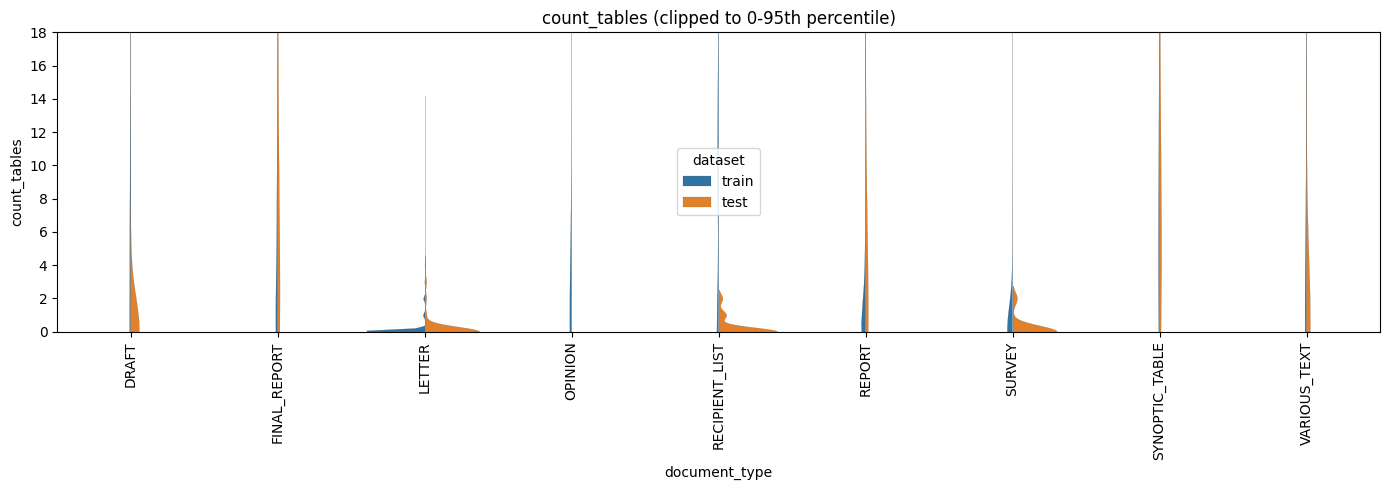

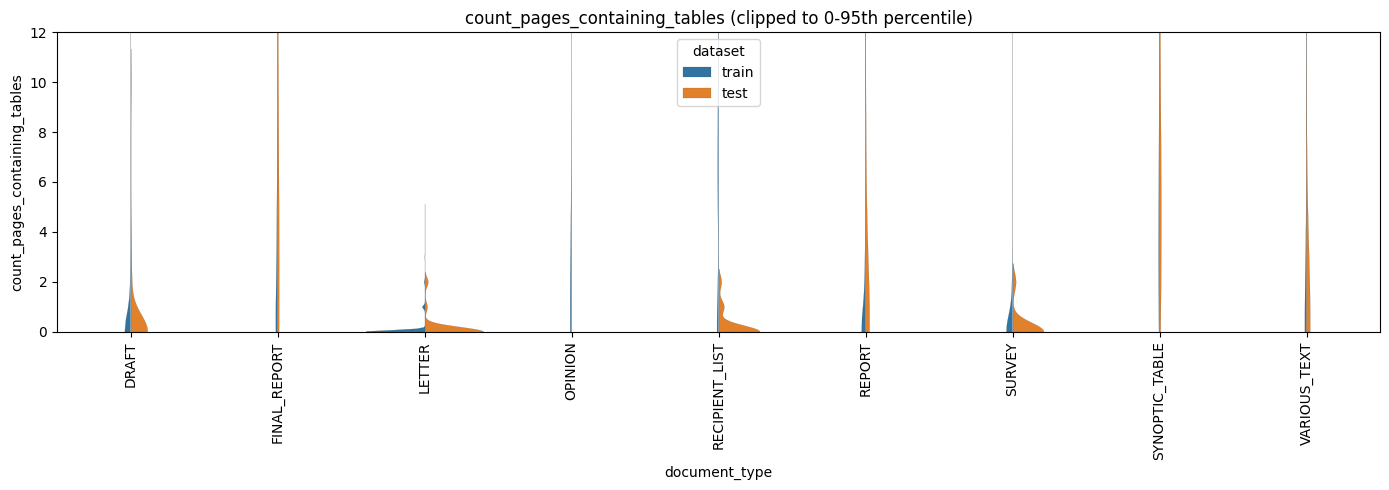

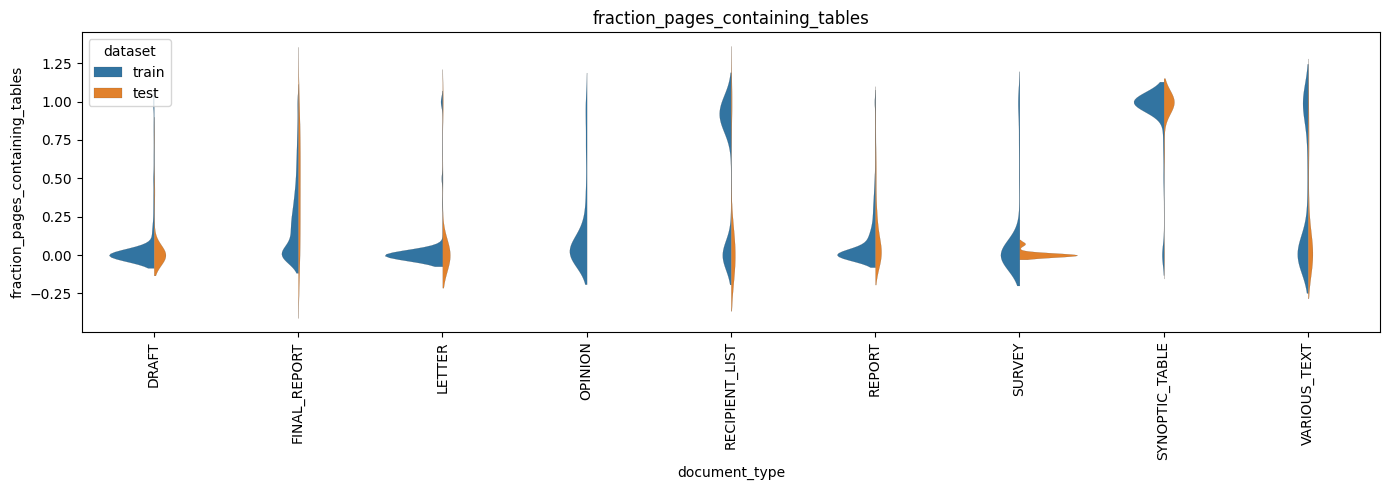

In [25]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

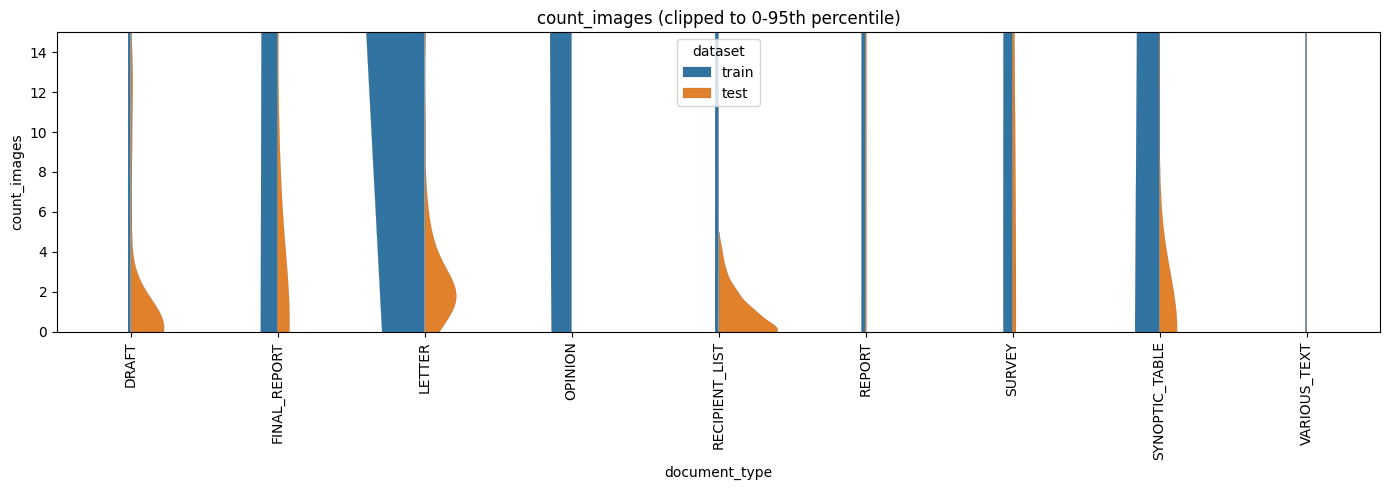

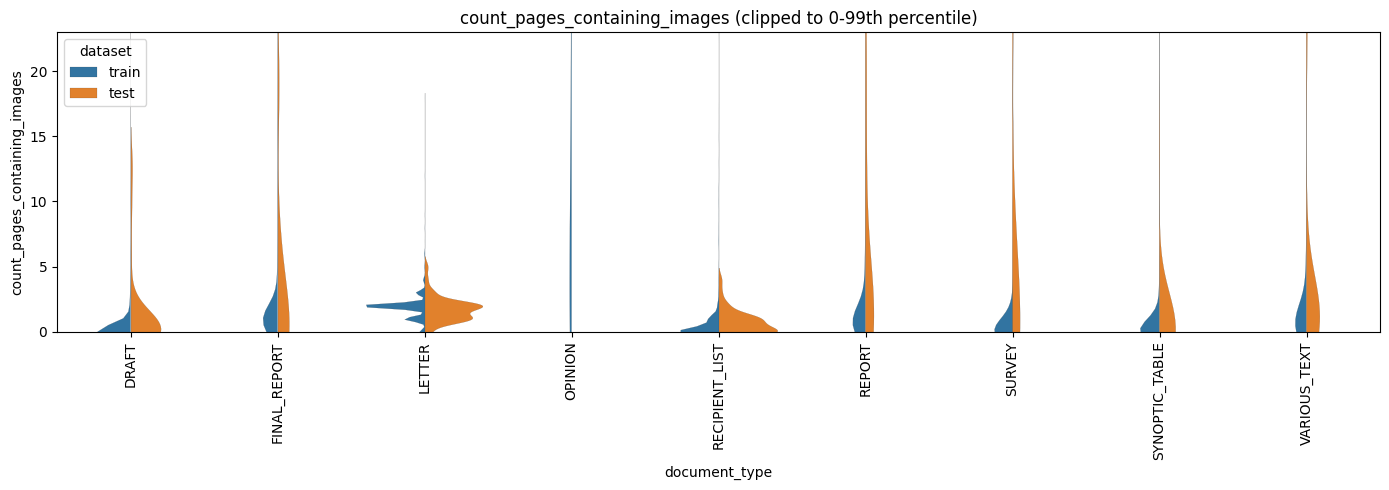

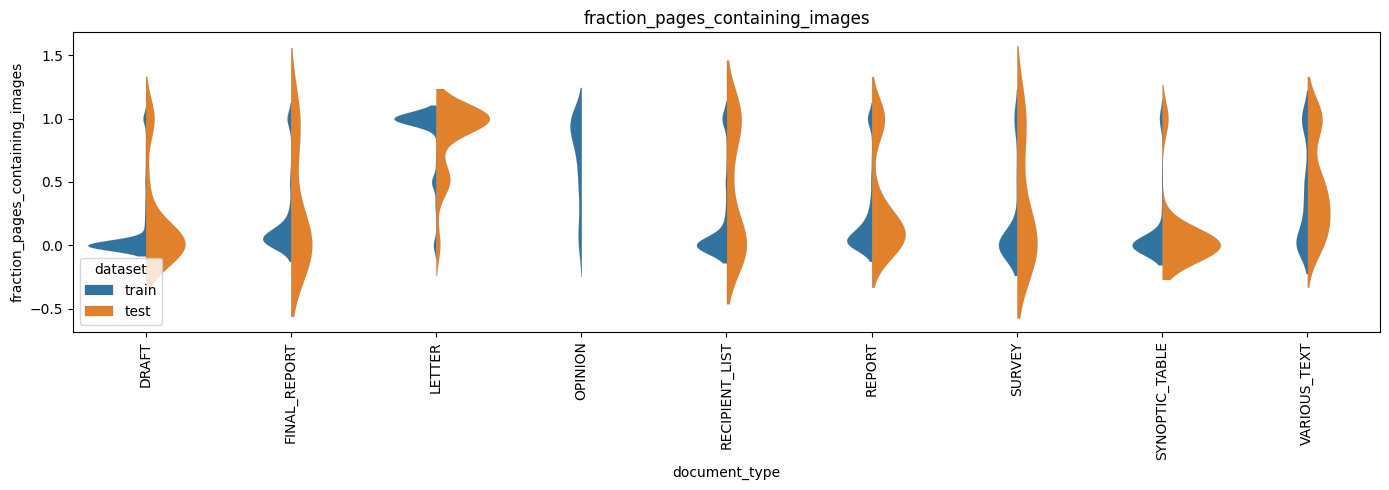

In [26]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

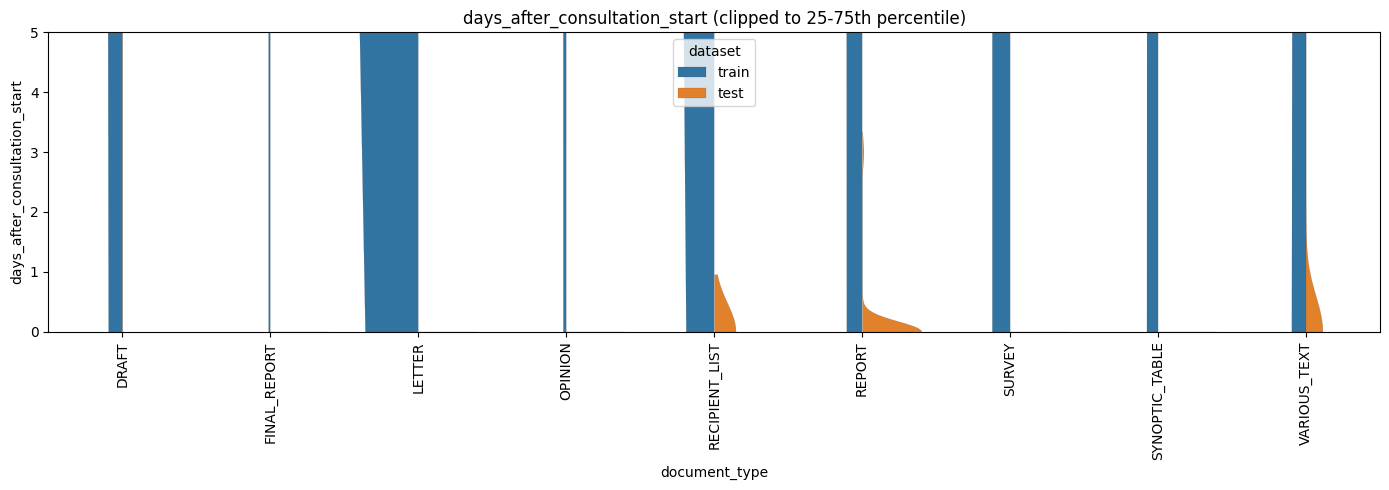

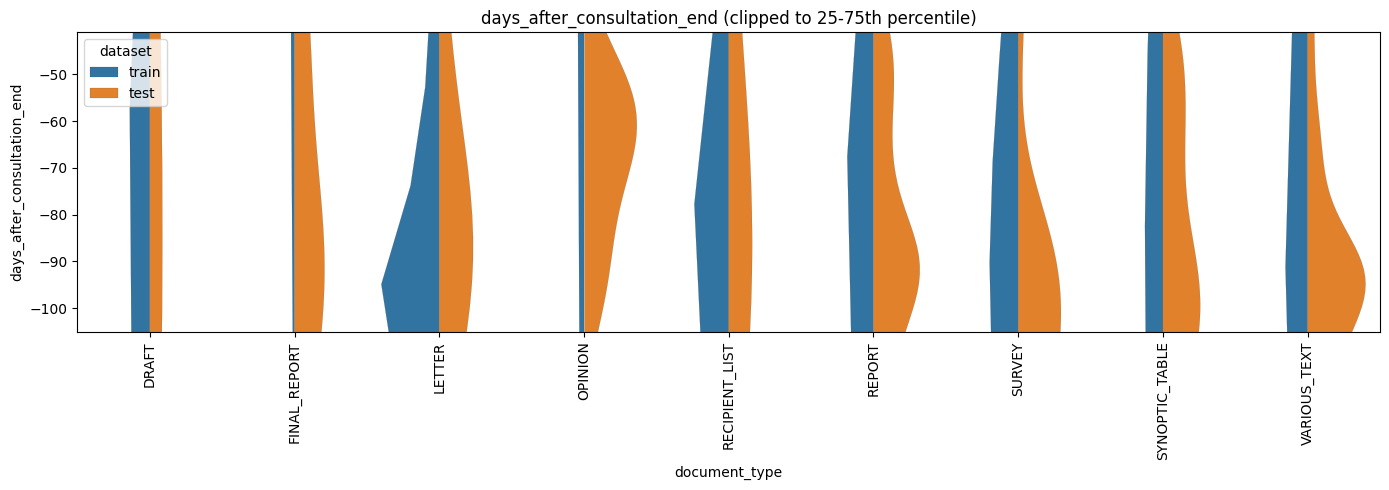

In [27]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

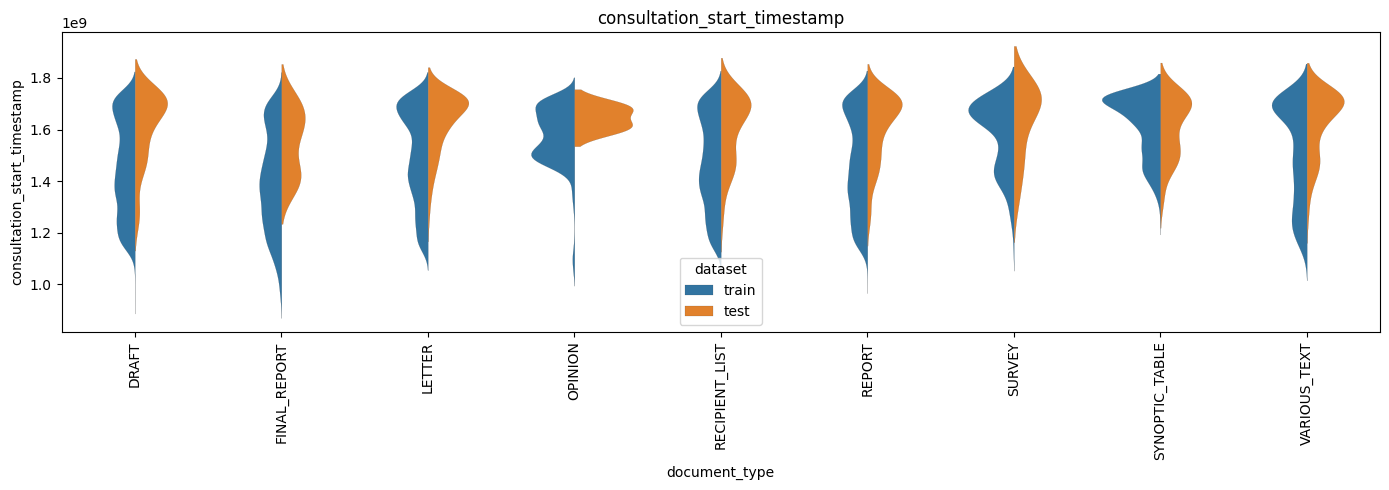

In [28]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [29]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train, fill_nulls=True)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1, fill_nulls=True)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2, fill_nulls=True)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (15411, 3084)
test_1 (403, 3084)
test_2 (403, 3084)


## Hyperoptimisation on test_1

In [30]:
def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 1000

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 50, 400, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            # {
            #     "type": "LogisticRegression",
            # },
            # {
            #     "type": "SVC",
            #     # "C": hyperopt.hp.lognormal("svm_C", 0, 1),
            #     "C": hyperopt.hp.loguniform("svm_C", np.log(1e-3), np.log(1e3)),
            #     "gamma": hyperopt.hp.loguniform("svm_gamma", np.log(1e-4), np.log(1e1)),
            #     "kernel": hyperopt.hp.choice(
            #         "svm_kernel",
            #         [
            #             {"type": "poly", "degree": quniform("svm_poly_degree", 2, 5, 1)},
            #             {"type": "rbf"},
            #             {"type": "sigmoid"},
            #         ],
            #     ),
            #     "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            # },
            {
                "type": "MLP",
                # Choose number of layers (1 to 3)
                "n_layers": quniform("n_layers", 1, 3, 1),
                # Neurons per layer (up to 3 layers, fill with dummy values if not used)
                "layer_1": quniform("layer_1", 16, 256, 16),
                "layer_2": quniform("layer_2", 16, 256, 16),
                "layer_3": quniform("layer_3", 16, 256, 16),
                "activation": hyperopt.hp.choice("activation", ["relu", "tanh", "logistic"]),
                "solver": hyperopt.hp.choice("solver", ["adam", "sgd"]),
                "learning_rate_init": hyperopt.hp.loguniform("learning_rate_init", np.log(1e-4), np.log(1e-1)),
                "alpha": hyperopt.hp.loguniform("alpha", np.log(1e-5), np.log(1e-1)),  # L2 regularization
                "batch_size": quniform("batch_size", 32, 256, 16),
            },
            # {
            #     "type": "MLP",
            #     "hidden_layer_sizes": hyperopt.hp.choice(
            #         "hidden_layer_sizes",
            #         [
            #             (quniform("hidden_layer_size", 64, 512, 32),),
            #             (
            #                 quniform("hidden_layer_size_0", 64, 512, 32),
            #                 quniform("hidden_layer_size_1", 64, 512, 32),
            #             ),
            #         ],
            #     ),
            # },
            # {
            #     "type": "RandomForest",
            #     "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
            #     "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
            #     "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
            #     "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
            #     "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
            #     "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            # },
        ],
    ),
}

if RUN_HYPEROPTIMIZATION:
    assert HYPERPARAMETERS is None, "HYPERPARAMETERS should be pre-defined when running hyperoptimization"
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(
        objective_function,
        search_space,
        algo=hyperopt.tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    display(best_params)
    assert trials.best_trial
    print(f"F1 {trials.best_trial['result']['f1']:.4f}")
    HYPERPARAMETERS = trials.best_trial["result"]["params"]
else:
    print("Using pre-defined hyperparameters")

Using pre-defined hyperparameters


In [31]:
mlflow.log_param("hyperparameters", HYPERPARAMETERS)

{'classifier': {'type': 'SVC',
  'C': 1.0,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': {'type': 'rbf'}},
 'pca_n_components': 100}

## CV

In [32]:
mlflow.sklearn.autolog()

2025/07/08 10:54:17 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [33]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring, verbose=1, n_jobs=-1
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(
    classifier_cv, X=X_train, y=y_train, cv=cv, verbose=2, n_jobs=-1
)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_res

{'fit_time': array([14.40681911, 14.35234308, 13.52138495, 14.03263187, 14.10582113]),
 'score_time': array([2.89547181, 2.84078383, 2.67981815, 2.81505203, 2.82681203]),
 'test_precision': array([0.9545898 , 0.95510402, 0.94647363, 0.9491923 , 0.94468359]),
 'test_recall': array([0.95588712, 0.95554835, 0.94841012, 0.95100584, 0.9467878 ]),
 'test_f1': array([0.95403028, 0.95360523, 0.9464018 , 0.94910645, 0.94347021]),
 'test_pca_explained_variance': array([0.65645355, 0.65631908, 0.65700579, 0.65635359, 0.65629935]),
 'test_accuracy': array([0.95588712, 0.95554835, 0.94841012, 0.95100584, 0.9467878 ]),
 'test_top_k_accuracy': array([0.98637691, 0.98734588, 0.98215445, 0.98377677, 0.9779364 ])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


In [35]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in cv_scores.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9515,
 'cv_f1': 0.9493,
 'cv_pca_explained_variance': 0.6565,
 'cv_precision': 0.95,
 'cv_recall': 0.9515,
 'cv_top_k_accuracy': 0.9835}


                precision    recall  f1-score   support

         DRAFT       0.91      0.95      0.93      3122
  FINAL_REPORT       0.98      0.98      0.98      1850
        LETTER       0.99      1.00      1.00      3304
       OPINION       0.98      0.96      0.97       907
RECIPIENT_LIST       0.99      1.00      1.00      2188
        REPORT       0.92      0.98      0.95      2558
        SURVEY       0.97      0.86      0.91       198
SYNOPTIC_TABLE       0.90      0.81      0.85       604
  VARIOUS_TEXT       0.78      0.55      0.64       680

      accuracy                           0.95     15411
     macro avg       0.94      0.90      0.91     15411
  weighted avg       0.95      0.95      0.95     15411



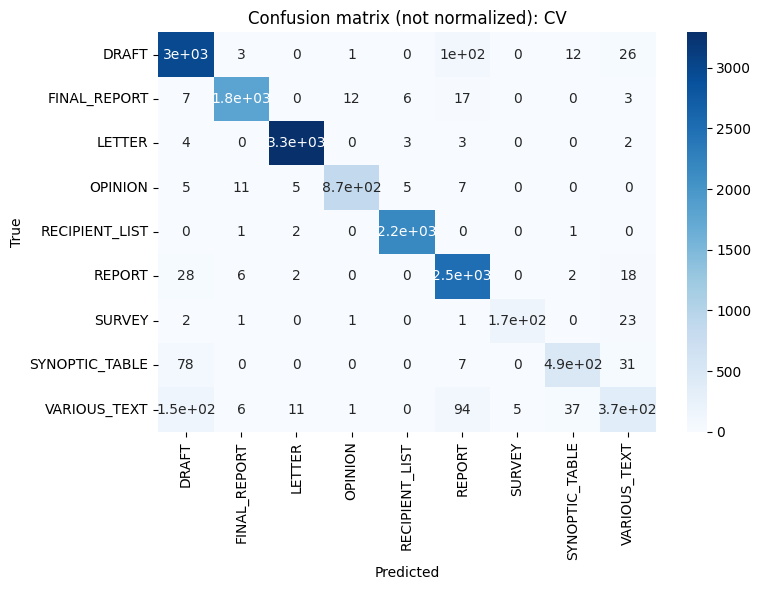

In [36]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [37]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/07/08 10:54:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/07/08 10:56:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.88      0.90      0.89        58
  FINAL_REPORT       0.90      0.60      0.72        15
        LETTER       0.99      1.00      0.99        79
       OPINION       0.57      1.00      0.73         4
RECIPIENT_LIST       1.00      1.00      1.00        37
        REPORT       0.81      0.93      0.87        95
        SURVEY       1.00      0.91      0.95        11
SYNOPTIC_TABLE       0.93      0.91      0.92        46
  VARIOUS_TEXT       0.89      0.72      0.80        58

      accuracy                           0.90       403
     macro avg       0.89      0.89      0.87       403
  weighted avg       0.91      0.90      0.90       403



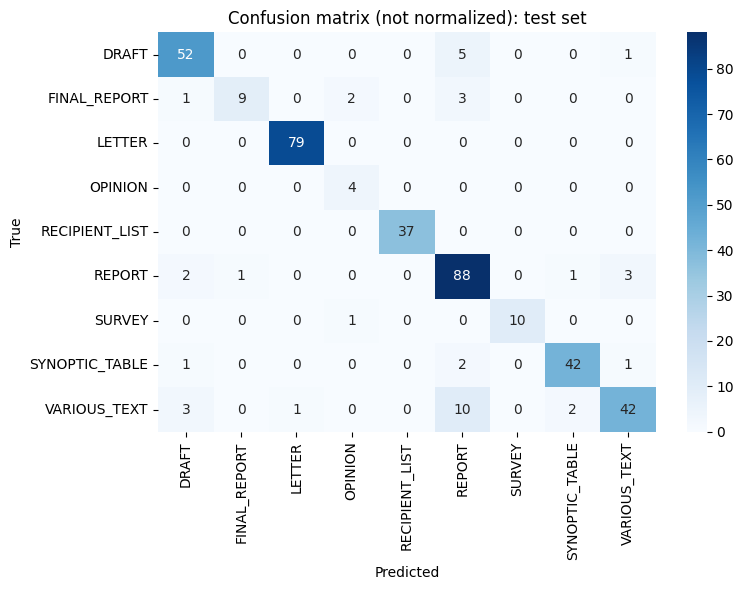

{'test_accuracy': 0.9007,
 'test_f1': 0.8994,
 'test_precision': 0.9059,
 'test_recall': 0.9007}


In [38]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance

In [39]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [40]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

        LETTER       1.00      1.00      1.00         6
RECIPIENT_LIST       1.00      1.00      1.00         9
        REPORT       0.82      1.00      0.90         9
        SURVEY       1.00      1.00      1.00         8
SYNOPTIC_TABLE       0.90      0.90      0.90        10
  VARIOUS_TEXT       0.67      0.40      0.50         5

      accuracy                           0.91        47
     macro avg       0.90      0.88      0.88        47
  weighted avg       0.91      0.91      0.91        47


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00        11
        LETTER       1.00      1.00      1.00         5
        REPORT  

## Comparison to the rule-based model

In [41]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.74% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 4.22% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.99% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document

                precision    recall  f1-score   support

         DRAFT       0.63      1.00      0.77        44
  FINAL_REPORT       1.00      0.50      0.67         2
        LETTER       1.00      1.00      1.00        75
RECIPIENT_LIST       1.00      1.00      1.00        35
        REPORT       0.98      0.79      0.88        72
        SURVEY       1.00      1.00      1.00         9
SYNOPTIC_TABLE       0.97      0.81      0.88        42
  VARIOUS_TEXT       1.00      0.86      0.93        29

      accuracy                           0.91       308
     macro avg       0.95      0.87      0.89       308
  weighted avg       0.94      0.91      0.91       308



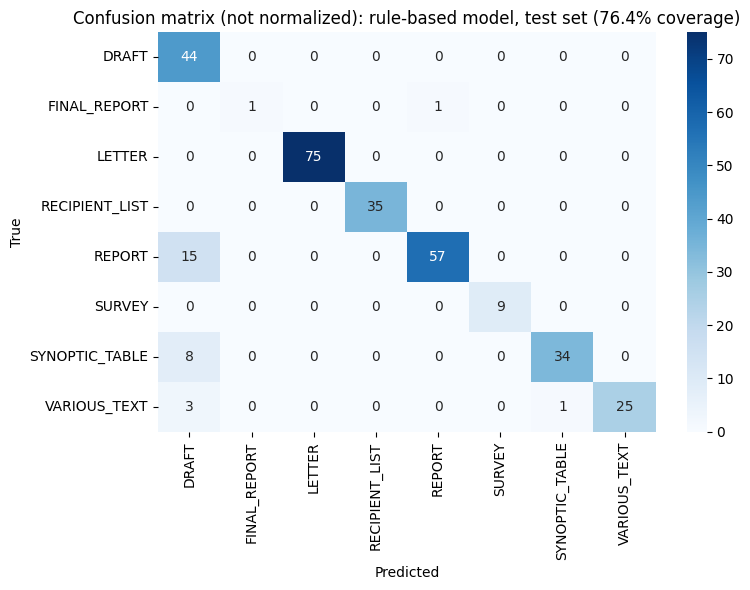

In [42]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

coverage = np.mean(y_test_predicted_rules.notna())
print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title=f"rule-based model, test set ({100 * coverage:.1f}% coverage)",
    # normalize="true",
)

## Display all test samples & predictions

In [43]:
df_display = df_input_test_2.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_2_predicted

df_display[
    [
        "document_uuid",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f"color: {'green' if row[col] == row['document_type'] else 'red'}"
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_uuid,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
44880,1CAJp8jUMT9piN3wtdGec1,tg,vnl,doc,Medienmitteilung Verfassung Notare,VARIOUS_TEXT,VARIOUS_TEXT,VARIOUS_TEXT
47410,1CAJpBUGPRrLeX8a3zkdUM,zh,vnl,doc,"Synopse IVöB 2001, IVöB 2019, VRöB, SVO",SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
40094,1CAJp3mQ3vj5MMJ6myTGUV,ar,vnl,doc,Vernehmlassungsentwurf (öV-Konzept) inkl. Beilagen,REPORT,DRAFT,VARIOUS_TEXT
47261,1CAJpBJxJMBuxmwe97PEBm,zh,vnl,doc,Verordnungsänderung Schattenwurfregelung,DRAFT,nan,DRAFT
41609,1CAJp5AojtBLEQa6Ldd2Td,bs,vnl,doc,Gesetzesentwurf,DRAFT,DRAFT,DRAFT
40062,1CAJp3k2TGWi2EnPc45AMQ,ar,vnl,doc,Begleitschreiben Vernehmlassungseröffnung,LETTER,LETTER,LETTER
47343,1CAJpBPG1WPKGQrvRkVg9c,zh,vnl,doc,Vernehmlassungsvorlage Beitrittsgesetz (BeiG),DRAFT,DRAFT,DRAFT
48508,1CC2sGhaCrVLZQtLu2PgWp,zh,vnl,doc,Synopse Variante Steuergericht,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
52478,1CMCsdUSXm7cLiQiLYcBXw,gl,vnl,doc,Adressatenliste,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
44876,1CAJp8jQPoZHwNrqXeqTxw,tg,vnl,doc,Medienmitteilung Beitragsgesetz,VARIOUS_TEXT,VARIOUS_TEXT,VARIOUS_TEXT


***

# End run

In [44]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [45]:
mlflow.end_run()

🏃 View run blushing-quail-761 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/66ff7939592748d2be53fdfc3672b98d
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
